In [1]:
import os

import fitsio
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
from pandas import read_csv

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
oscpath = os.path.join( os.getenv('IM_RESEARCH_DIR'), 'people', 'kephart' )
galspecpath = os.path.join( os.getenv('IM_DATA_DIR'), 'sdss', 'dr8' )

### Read the Open Supernova Catalog

In [4]:
allosc = read_csv(os.path.join(oscpath, 'osc.csv'))
nallosc = len(allosc)
print('Read {} supernovae in OSC catalog.'.format(nallosc))

Read 41133 supernovae in OSC catalog.


In [5]:
allosc

,Name,Disc. Date,mmax,Host Name,R.A.,Dec.,z,Type,Phot.,Spec.,Radio,X-ray
0,SN1987A,1987/02/24,1.90,LMC,"05:35:28.020,05:35:28,05:35:28.01,05:35:27.99","-69:16:11.07,-69:16:11,-69:16:11.61,-69:16:11....","9.51e-06,9.78e-06,1.02e-05,1.06e-05,1.07e-05,1...",II Pec,3332.0,36.0,NaN,105.0
1,SN2003dh,2003/03/31,12.62,A104450+2131,"10:44:50.030,10:44:50.01,10:44:50.018","+21:31:18.15,+21:31:17.8,+21:31:17.80,+21:31:1...",0.1685,Ic BL,2781.0,13.0,NaN,NaN
2,SN2011fe,2011/08/24,9.48,NGC 5457,"14:03:05.711,14:03:05.76,14:03:05.81,14:03:05.80","+54:16:25.22,+54:16:25.32,+54:16:25.4,+54:16:2...",0.000804,Ia,2728.0,80.0,0.0,0.0
3,SN1993J,1993/03/28,9.91,NGC 3031,"09:55:24.7747,09:55:24.95,09:55:25.00","+69:01:13.702,+69:01:13.38,+69:01:13.01,+69:01...",-0.000113,IIb,1814.0,50.0,NaN,NaN
4,SN2002ap,2002/01/29,12.04,NGC 628,"01:36:23.85,01:36:23.87","+15:45:13.2,+15:45:13.21,+15:45:13.0",0.002108,Ic BL,1781.0,39.0,NaN,NaN
5,SN2009ip,2012/07/24,12.01,NGC 7259,"22:23:08.3,22:23:08.26","-28:56:52,-28:56:52.4,-28:56:52.40",0.005944,LBV to IIn,1569.0,240.0,NaN,NaN
6,SN2011dh,2011/06/01,12.06,NGC 5194,"13:30:05.1055,13:30:05.12,13:30:05.124","+47:10:10.922,+47:10:11.3,+47:10:10.81,+47:10:...",0.001638,IIb,1333.0,71.0,NaN,NaN
7,SN2000cx,2000/07/17,12.90,NGC 524,"01:24:46.19,01:24:46.15","+09:30:31.3,+09:30:30.9,+09:30:30.89","0.007929,0.008076",Ia Pec,1316.0,45.0,NaN,NaN
8,SN1999em,1999/10/29,12.80,NGC 1637,"04:41:27.04,04:41:27.168,04:41:27.13,04:41:27.05","-02:51:45.2,-02:51:45.828,-02:51:45.4,-02:51:4...",0.002392,II P,1207.0,72.0,NaN,NaN
9,SN1999ee,1999/10/07,14.50,IC 5179,"22:16:09.40,22:16:10.00","-36:50:31.5,-36:50:39.7,-36:50:39.70","0.01141,0.01141",Ia,1169.0,26.0,NaN,NaN


Since we're going to be matching against the SDSS database, we probably only want objects whose host galaxy name is populated (maybe)?

In [6]:
if False:
    keep = ['nan' not in str(hostname).lower() for hostname in allosc['Host Name']]
    nosc = int(np.sum(keep))
    print('Keeping {} OSC supernovae with known host galaxies.'.format(nosc))
    osc = allosc[keep]
    osc = osc.reset_index(drop=True)
else:
    osc = allosc.copy()
    nosc = len(osc)

### Loop on each supernova and get the mean coordinates and redshifts.

In [7]:
def _hms(ra):
    """Convert RA in hms to decimal degrees."""
    sep1 = ra.find(':')
    hh = int( ra[0:sep1] )
    sep2 = ra[sep1+1:].find(':')
    if sep2 == -1:
        mm = float( ra[sep1+1:] )
        ss = 0.0
    else:
        mm = int( ra[sep1+1:sep1+sep2+1] )
        ss = float( ra[sep1+sep2+2:] )
    return hh*15.0 + mm/4.0 + ss/240.0

In [8]:
def _dms(dec):
    """Convert Dec in dms to decimal degrees."""
    Csign = dec[0]
    if Csign == '-':
        sign = -1.0
        off = 1
    elif Csign == '+':
        sign = 1.0
        off = 1
    else:
        sign = 1.0
        off = 0
    sep1 = dec.find(':')
    deg = int( dec[off:sep1] )
    sep2 = dec[sep1+1:].find(':')
    if sep2 == -1:
        arcmin = float( dec[sep1+1:] )
        arcsec = 0.0
    else:
        arcmin = int( dec[sep1+1:sep1+sep2+1] )
        arcsec = float( dec[sep1+sep2+2:] )
    
    return sign * (deg + (arcmin*5.0/3.0 + arcsec*5.0/180.0) / 100.0)

In [9]:
ra, dec, z, good = np.zeros(nosc), np.zeros(nosc), np.zeros(nosc), np.ones(nosc).astype(bool)
for ii in range(nosc):
    sra = str(osc['R.A.'][ii]).split(',')
    sdec = str(osc['Dec.'][ii]).split(',')
    sz = str(osc['z'][ii]).split(',')
    if 'nan' in sra or 'nan' in sz:
        good[ii] = False
        continue
    nn = len(sra)
    ra1 = np.zeros(nn)
    dec1 = np.zeros(nn)
    for jj, (rr, dd) in enumerate(zip(sra, sdec)):
        #print(ii, rr, dd)
        if ':' in rr:
            ra1[jj] = _hms(rr)
            dec1[jj] = _dms(dd)
        else:
            ra1[jj] = rr
            dec1[jj] = dd
    ra[ii] = np.mean(ra1)
    dec[ii] = np.mean(dec1)
    z[ii] = np.mean(np.array(sz).astype('f4'))

In [10]:
oscgood = Table.from_pandas(osc[good])
noscgood = len(oscgood)
print('Found {} OSC supernovae with good coordinates and redshifts.'.format(noscgood))

Found 15835 OSC supernovae with good coordinates and redshifts.


In [11]:
oscgood.add_column(Column(ra[good], name='MEAN_RA'))
oscgood.add_column(Column(dec[good], name='MEAN_DEC'))
oscgood.add_column(Column(z[good], name='MEAN_Z'))

In [12]:
osc.loc[z.argmax()]

Name          GRB 090429B
Disc. Date     2009/04/29
mmax                  NaN
Host Name             NaN
R.A.          14:02:41.28
Dec.          +32:10:01.2
z                     9.4
Type                 LGRB
Phot.                 NaN
Spec.                 NaN
Radio                 NaN
X-ray                 NaN
Name: 33212, dtype: object

In [13]:
oscgood

Name,Disc. Date,mmax,Host Name,R.A.,Dec.,z,Type,Phot.,Spec.,Radio,X-ray,MEAN_RA,MEAN_DEC,MEAN_Z
str30,str21,float64,str30,str106,str146,str125,str19,float64,float64,float64,float64,float64,float64,float64
SN1987A,1987/02/24,1.9,LMC,"05:35:28.020,05:35:28,05:35:28.01,05:35:27.99","-69:16:11.07,-69:16:11,-69:16:11.61,-69:16:11.50,-69:16:11.5,-69:16:11.6,+05:35:28.020","9.51e-06,9.78e-06,1.02e-05,1.06e-05,1.07e-05,1.11e-05,1.12e-05,1.13e-05,1.14e-05,1.15e-05,1.16e-05,1.17e-05,1.19e-05,1.22e-05",II Pec,3332.0,36.0,--,105.0,83.8666875,-69.2698041667,1.10492865133e-05
SN2003dh,2003/03/31,12.62,A104450+2131,"10:44:50.030,10:44:50.01,10:44:50.018","+21:31:18.15,+21:31:17.8,+21:31:17.80,+21:31:17.89",0.1685,Ic BL,2781.0,13.0,--,--,161.208413889,21.5216435185,0.168500006199
SN2011fe,2011/08/24,9.48,NGC 5457,"14:03:05.711,14:03:05.76,14:03:05.81,14:03:05.80","+54:16:25.22,+54:16:25.32,+54:16:25.4,+54:16:25.39,+54:16:25.3",0.000804,Ia,2728.0,80.0,0.0,0.0,210.774042708,54.2737034722,0.000804000010248
SN1993J,1993/03/28,9.91,NGC 3031,"09:55:24.7747,09:55:24.95,09:55:25.00","+69:01:13.702,+69:01:13.38,+69:01:13.01,+69:01:13.0,+69:01:13.4",-0.000113,IIb,1814.0,50.0,--,--,148.853784306,69.0203788889,-0.000113000001875
SN2002ap,2002/01/29,12.04,NGC 628,"01:36:23.85,01:36:23.87","+15:45:13.2,+15:45:13.21,+15:45:13.0",0.002108,Ic BL,1781.0,39.0,--,--,24.0994166667,15.7536680556,0.00210799998604
SN2009ip,2012/07/24,12.01,NGC 7259,"22:23:08.3,22:23:08.26","-28:56:52,-28:56:52.4,-28:56:52.40",0.005944,LBV to IIn,1569.0,240.0,--,--,335.7845,-28.9478333333,0.0059440000914
SN2011dh,2011/06/01,12.06,NGC 5194,"13:30:05.1055,13:30:05.12,13:30:05.124","+47:10:10.922,+47:10:11.3,+47:10:10.81,+47:10:11.301",0.001638,IIb,1333.0,71.0,--,--,202.52131875,47.1697251852,0.0016380000161
SN2000cx,2000/07/17,12.9,NGC 524,"01:24:46.19,01:24:46.15","+09:30:31.3,+09:30:30.9,+09:30:30.89","0.007929,0.008076",Ia Pec,1316.0,45.0,--,--,21.192375,9.50863888889,0.00800250004977
SN1999em,1999/10/29,12.8,NGC 1637,"04:41:27.04,04:41:27.168,04:41:27.13,04:41:27.05","-02:51:45.2,-02:51:45.828,-02:51:45.4,-02:51:45.22,-02:51:45.8",0.002392,II P,1207.0,72.0,--,--,70.3629041667,-2.86261444444,0.00239200005308


For reference, here are the SNe with bad or no coordinates.

In [14]:
osc[~good]

,Name,Disc. Date,mmax,Host Name,R.A.,Dec.,z,Type,Phot.,Spec.,Radio,X-ray
19,Gaia16apu,2016/05/21,15.54,NaN,"17:03:57.90,17:03:57.888,17:03:57.84","+76:46:10.30,+76:46:10.29,+76:46:10.2",NaN,NaN,860.0,NaN,NaN,NaN
21,Gaia16ael,2016/02/17,15.24,NaN,"16:38:53.70,16:38:53.67,16:38:53.76","+58:35:26.90,+58:35:26.9,+58:35:26.88",NaN,Candidate,795.0,NaN,NaN,NaN
33,Gaia16aoy,2016/05/15,15.35,NaN,"10:54:59.30,10:54:59.294,10:54:59.28","+68:11:53.10,+68:11:53.12,+68:11:53.16",NaN,NaN,663.0,NaN,NaN,NaN
88,Gaia16aka,2016/03/31,15.32,NaN,"14:48:08.20,14:48:08.25,14:48:08.16","+37:13:58.70,+37:13:58.7,+37:13:58.8",NaN,NaN,390.0,NaN,NaN,NaN
112,Gaia16afb,2016/02/19,16.91,NaN,"17:40:02.30,17:40:02.33,17:40:02.4","+50:21:41.00,+50:21:40.9,+50:21:41.04",NaN,NaN,324.0,NaN,NaN,NaN
134,Gaia16aaf,2016/01/19,17.05,NaN,"04:26:12.40,04:26:12.42,04:26:12.408","+42:55:05.60,+42:55:05.6,+42:55:05.52",NaN,NaN,286.0,NaN,NaN,NaN
151,Gaia16alz,2016/04/26,15.21,NaN,"18:55:01.30,18:55:01.330,18:55:01.44","+01:38:56.90,+01:38:56.94",NaN,NaN,269.0,NaN,NaN,NaN
152,Gaia16avv,2016/07/19,14.76,2MASX J04051578+2122240,"04:05:15.40,04:05:15.423,04:05:15.432,04:05:15...","+21:22:22.70,+21:22:22.73,+21:22:22.8,+21:22:22.6",NaN,NaN,269.0,NaN,NaN,NaN
200,PTF11rfr,2010/09/08,17.71,NaN,01:42.3,+29:16,NaN,NaN,224.0,NaN,NaN,NaN
205,Gaia16aam,2016/01/22,16.61,NaN,"16:16:34.50,16:16:34.56","+65:22:02.10,+65:22:02.1,+65:22:02.28",NaN,Candidate,221.0,NaN,NaN,NaN


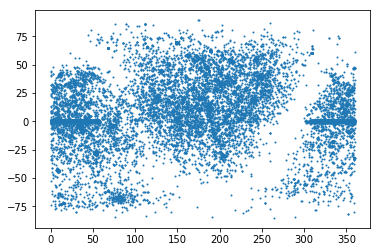

In [15]:
fig, ax = plt.subplots()
ax.scatter(oscgood['MEAN_RA'], oscgood['MEAN_DEC'], s=1)

### Read the SDSS galspecinfo catalog and match.

In [16]:
_sdssinfo = fitsio.FITS(os.path.join(galspecpath, 'galSpecInfo-dr8.fits'))
print(_sdssinfo[1])
cols = ['SPECOBJID', 'RA', 'DEC', 'PLATEID', 'MJD', 'FIBERID', 'Z']
sdssinfo = Table(_sdssinfo[1].read(columns=cols))


  file: /Users/ioannis/research/data/sdss/dr8/galSpecInfo-dr8.fits
  extension: 1
  type: BINARY_TBL
  rows: 1843200
  column info:
    SPECOBJID          S19  
    RELIABLE            i2  
    PLATEID             i2  
    MJD                 i4  
    FIBERID             i2  
    PHOTOID             i2  array[5]
    RA                  f4  
    DEC                 f4  
    PLUG_MAG            f4  array[5]
    PRIMTARGET          i2  
    SECTARGET           i2  
    TARGETTYPE         S19  
    SPECTROTYPE         S6  
    SUBCLASS           S21  
    Z                   f4  
    Z_ERR               f4  
    Z_WARNING           i2  
    V_DISP              f4  
    V_DISP_ERR          f4  
    SN_MEDIAN           f4  
    E_BV_SFD            f4  
    ZTWEAK              f4  
    ZTWEAK_ERR          f4  
    SPECTRO_MAG         f4  array[3]
    KCOR_MAG            f4  array[3]
    KCOR_MODEL_MAG      f4  array[5]
    RELEASE            S12  


In [17]:
_sdssprops = fitsio.FITS(os.path.join(galspecpath, 'galSpecExtra-dr8.fits'))
print(_sdssprops[1])
cols = ['LGM_TOT_P50', 'OH_P50', 'SFR_TOT_P50', 'SPECSFR_TOT_P50', 'BPTCLASS']
sdssprops = Table(_sdssprops[1].read(columns=cols))


  file: /Users/ioannis/research/data/sdss/dr8/galSpecExtra-dr8.fits
  extension: 1
  type: BINARY_TBL
  rows: 1843200
  column info:
    SPECOBJID          S19  
    PLATEID             i4  
    MJD                 i4  
    FIBERID             i4  
    BPTCLASS            i2  
    LGM_TOT_P2P5        f4  
    LGM_TOT_P16         f4  
    LGM_TOT_P50         f4  
    LGM_TOT_P84         f4  
    LGM_TOT_P97P5       f4  
    LGM_FIB_P2P5        f4  
    LGM_FIB_P16         f4  
    LGM_FIB_P50         f4  
    LGM_FIB_P84         f4  
    LGM_FIB_P97P5       f4  
    OH_P2P5             f4  
    OH_P16              f4  
    OH_P50              f4  
    OH_P84              f4  
    OH_P97P5            f4  
    OH_ENTROPY          f4  
    SFR_TOT_P2P5        f4  
    SFR_TOT_P16         f4  
    SFR_TOT_P50         f4  
    SFR_TOT_P84         f4  
    SFR_TOT_P97P5       f4  
    SFR_TOT_ENTROPY     f4  
    SFR_FIB_P2P5        f4  
    SFR_FIB_P16         f4  
    SFR_FIB_P50         f

Toss out SDSS galaxies with RA, Dec coordinates equal to -9999 and also require a stellar mass and a redshift greater than zero.

In [18]:
sdssgood = np.where( (sdssinfo['RA'] >= 0) * (sdssinfo['RA'] <= 360) *
                    (sdssinfo['Z'] > 0) *
                    (sdssprops['LGM_TOT_P50'] > 0) )[0]
sdssinfo = sdssinfo[sdssgood]
sdssprops = sdssprops[sdssgood]
print('Read {} SDSS galaxies with good coordinates and stellar masses.'.format(len(sdssinfo)))

Read 930420 SDSS galaxies with good coordinates and stellar masses.


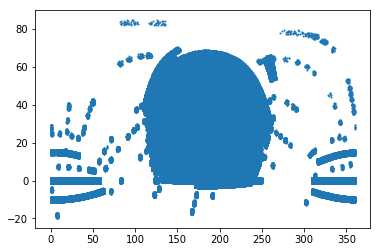

In [19]:
fig, ax = plt.subplots()
ax.scatter(sdssinfo['RA'], sdssinfo['DEC'], s=1)

In [20]:
scoord = SkyCoord(ra=sdssinfo['RA']*u.deg, dec=sdssinfo['DEC']*u.deg)
ocoord = SkyCoord(ra=oscgood['MEAN_RA']*u.deg, dec=oscgood['MEAN_DEC']*u.deg)
_, sep2d, _ = ocoord.match_to_catalog_sky(scoord)

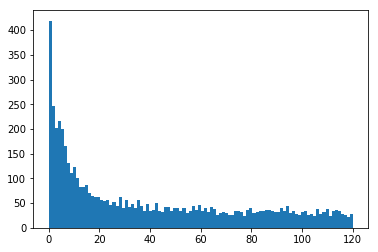

In [21]:
fig, ax = plt.subplots()
_, _, _ = ax.hist(sep2d.arcsec, bins=100, range=(0, 120))

In [22]:
radii = np.array([1, 5, 10, 15, 20, 30, 40, 60])
nmatch = np.zeros_like(radii)
for ii, rr in enumerate(radii):
    indx_sdss1, indx_osc1, _, _ = ocoord.search_around_sky(scoord, rr * u.arcsec)
    nmatch[ii] = len(indx_sdss1)
    print(rr, nmatch[ii])

1 429
5 1307
10 2033
15 2502
20 2881
30 3489
40 4057
60 5341


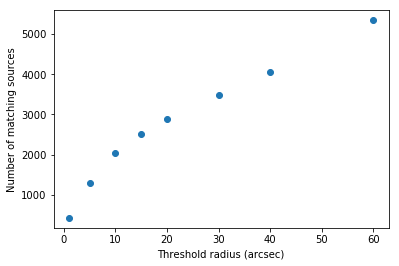

In [23]:
fig, ax = plt.subplots()
ax.scatter(radii, nmatch)
ax.set_xlabel('Threshold radius (arcsec)')
ax.set_ylabel('Number of matching sources')

### Match galaxies within 20 arcsec but also take into account the redshift difference.

In [24]:
rad = 20.0 * u.arcsec
indx_sdss, indx_osc, d2d, _ = ocoord.search_around_sky(scoord, rad)

dz = np.zeros(len(indx_osc))
for ii, oo in enumerate(oscgood[indx_osc]):
    dz[ii] = np.abs(oo['MEAN_Z'] - sdssinfo['Z'][indx_sdss[ii]]) / sdssinfo['Z'][indx_sdss[ii]]
goodz = dz < 0.05
nmatch = int(np.sum(goodz))

print('Found {} matches within {} of which {} have |dz/z|<0.05'.format(len(indx_sdss), rad, nmatch))

Found 2881 matches within 20.0 arcsec of which 2435 have |dz/z|<0.05


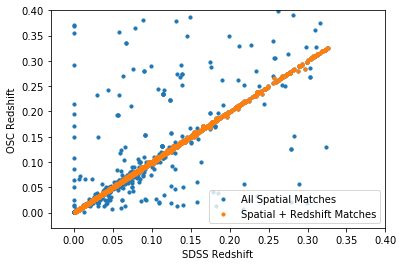

In [25]:
fig, ax = plt.subplots()
ax.scatter(sdssinfo['Z'][indx_sdss], oscgood['MEAN_Z'][indx_osc], 
           s=10, label='All Spatial Matches')
ax.scatter(sdssinfo['Z'][indx_sdss[goodz]], oscgood['MEAN_Z'][indx_osc[goodz]], 
           s=10, label='Spatial + Redshift Matches')
ax.set_xlabel('SDSS Redshift')
ax.set_ylabel('OSC Redshift')
ax.set_xlim(-0.03, 0.4)
ax.set_ylim(-0.03, 0.4)
ax.legend(loc='lower right')

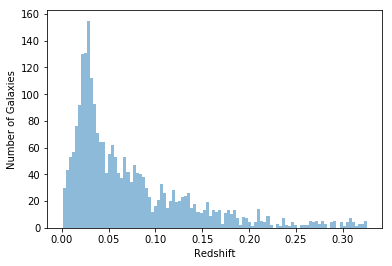

In [26]:
fig, ax = plt.subplots()
_, _, _ = ax.hist(sdssinfo['Z'][indx_sdss[goodz]], 
                  bins=100, alpha=0.5)
ax.set_xlabel('Redshift')
ax.set_ylabel('Number of Galaxies')

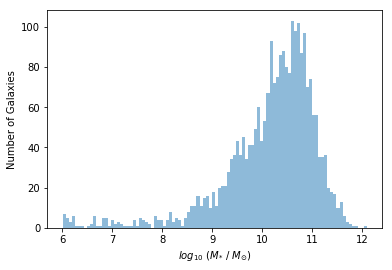

In [27]:
fig, ax = plt.subplots()
_, _, _ = ax.hist(sdssprops['LGM_TOT_P50'][indx_sdss[goodz]], 
                  bins=100, alpha=0.5)
ax.set_xlabel(r'$log_{10}\ (M_{*}\ /\ M_{\odot})$')
ax.set_ylabel('Number of Galaxies')

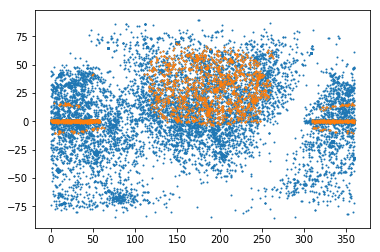

In [28]:
fig, ax = plt.subplots()
ax.scatter(oscgood['MEAN_RA'], oscgood['MEAN_DEC'], s=1)
#ax.scatter(oscra[oscmatch], oscdec[oscmatch], s=1)
ax.scatter(sdssinfo['RA'][indx_sdss[goodz]], sdssinfo['DEC'][indx_sdss[goodz]], s=1)

### Write out the matched catalogs.

In [29]:
oscout = oscgood[indx_osc[goodz]]
oscout

Name,Disc. Date,mmax,Host Name,R.A.,Dec.,z,Type,Phot.,Spec.,Radio,X-ray,MEAN_RA,MEAN_DEC,MEAN_Z
str30,str21,float64,str30,str106,str146,str125,str19,float64,float64,float64,float64,float64,float64,float64
SN2001kp,2001/03/21,18.2,A095153+0106,"09:51:53.064,09:51:53.04,09:51:53.00,09:51:53.08","+01:06:05.62,+01:06:05.76,+01:06:01.01,+01:06:05.8","0.063,0.0634",Ia,1.0,--,--,--,147.971025,1.10126319444,0.0631999969482
SN2014ct,2014/06/01,18.7,MCG +00-26-01,09:59:25.16,"-00:15:19.2,-00:15:19.19",0.048,Ia,1.0,1.0,--,--,149.854833333,-0.255333333333,0.0480000004172
PS1-11ai,2011/01/06,--,--,09:56:42.562,+00:55:47.69,"0.092,0.092",II P,--,--,--,--,149.177341667,0.929913888889,0.0920000001788
PS15cms,2015/10/17,--,--,09:58:35.10,+00:44:34.7,0.065,Ia,--,--,--,--,149.64625,0.742972222222,0.0649999976158
LSQ15bb,2014/12/24,21.5,--,09:58:52.16,+01:01:11.4,0.08,Ia,1.0,1.0,--,--,149.717333333,1.01983333333,0.0799999982119
SN2001kr,2001/03/26,19.1,A095916+0058,"09:59:15.79,09:59:15.84,09:59:16.00,09:59:15.75","+00:58:02.8,+00:58:02.28,+00:58:00.01,+00:58:02.4","0.088,0.0882",Ia,1.0,--,--,--,149.816020833,0.967186805556,0.0881000012159
SN2013U,2013/01/05,16.45,PGC 29001,10:01:12.00,"+00:19:42.3,+00:19:42.31",0.03451,Ia Pec,24.0,7.0,--,--,150.3,0.328416666667,0.0345100015402
PS15cvz,2015/10/13,--,--,10:05:41.49,+01:05:33.2,0.069,--,--,--,--,--,151.422875,1.09255555556,0.0689999982715
SN2016aws,2016/03/06,19.86,SDSS J101934.23-010033.6,"10:19:34.62,10:19:34.61","-01:00:32.62,-01:00:32.6","0.043,0.043",Ib,17.0,--,--,--,154.894229167,-1.00905833333,0.0430000014603


In [30]:
sdssout = sdssinfo[indx_sdss[goodz]].copy()
sdssout.add_columns(sdssprops[indx_sdss[goodz]].columns.values())
sdssout

SPECOBJID,PLATEID,MJD,FIBERID,RA,DEC,Z,BPTCLASS,LGM_TOT_P50,OH_P50,SFR_TOT_P50,SPECSFR_TOT_P50
bytes19,int16,int32,int16,float32,float32,float32,int16,float32,float32,float32,float32
300740371552430080,267,51608,455,147.971,1.10164,0.0632417,2,10.6165,-9999.0,-0.504578,-11.1692
301790680454293504,268,51633,180,149.859,-0.25392,0.0474776,5,11.3922,-9999.0,-0.873689,-12.2991
301844006768240640,268,51633,374,149.178,0.930241,0.0921183,2,10.6237,-9999.0,0.584954,-10.0958
301875617727539200,268,51633,489,149.647,0.742783,0.0648247,1,10.8014,9.09354,1.35652,-9.49671
301885238454282240,268,51633,524,149.722,1.02097,0.0817116,-1,10.2894,-9999.0,-1.64649,-11.9948
301898432593815552,268,51633,572,149.816,0.967329,0.0880019,3,10.2568,-9999.0,-0.228371,-10.5506
301905029663582208,268,51633,596,150.299,0.329321,0.0344885,1,10.4118,9.14995,0.537411,-9.91283
303023512514226176,269,51910,569,151.423,1.09169,0.0686446,4,10.757,-9999.0,0.135847,-10.6647
305133474874943488,271,51883,53,154.893,-1.00934,0.0432955,1,9.62503,8.56131,-0.157774,-9.84411


In [31]:
sdssfile = os.path.join(oscpath, 'galSpec-oscmatched.csv')
print('Writing {}'.format(sdssfile))
sdssout.write(sdssfile, format='csv', overwrite=True)

Writing /Users/ioannis/research/people/kephart/galSpec-oscmatched.csv


In [32]:
oscfile = os.path.join(oscpath, 'osc-galSpecmatched.csv')
print('Writing {}'.format(oscfile))
oscout.write(oscfile, format='csv', overwrite=True)

Writing /Users/ioannis/research/people/kephart/osc-galSpecmatched.csv
